# Automatizacion de busqueda de hyperparámetros 

Voy a hacerlo todo con clases, así será mas sencillo ahorrar memoria, o debería. 

Idealmente esto lo ejecutaria con papermill


In [3]:
#import libraries
import sys 
sys.path.append("..")

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from model import AnomalyTransformer
import gc
from torch import optim

from torch.utils.data import DataLoader,Dataset

# DATA

In [91]:
# class Data_anomSine(Dataset):
#     def __init__(self, length=100, amp=1, sf=0.1, f=2, phase=0, anoms=1, magnitud=None, window_size=100,stride=1,anoms_c=3,range_lenght=(10,35), context_anom=True,global_anom=True):
#         super().__init__()
#         self.list_anomalies=[]
#         self.anoms=anoms
#         self.range_lenght=range_lenght
#         self.anoms_c=anoms_c
#         self.magnitud=magnitud
        
#         self.sine_wave = Data_anomSine.sinne(length, amp, sf, f, phase)
#         if context_anom:
#             self.add_context_anom()
#         if global_anom:
#             self.add_global_anom()
#         self.array = Data_anomSine.windowed_view(self.sine_wave, window_size,stride=stride)
#         self.array = torch.from_numpy(self.array).unsqueeze(-1)


#     def __len__(self):
#         return self.array.shape[0]

#     def __getitem__(self, index):
#         return self.array[index]

#     @staticmethod
#     def sinne(length=100, amp=10, sf=0.1, f=2, phase=0):
#         x = torch.arange(0, length * sf, sf)
#         return (amp/4)*torch.randn(length) + amp * torch.sin(x * sf * 2 * torch.pi / (f/5) + phase) *torch.sin(x * sf * 2 * torch.pi / f + phase) 

#     def add_global_anom(self):
#         if self.magnitud is None:
#             self.magnitud = self.sine_wave.max().item() - self.sine_wave.min().item()
#         index = torch.from_numpy(np.random.choice(np.arange(0, self.sine_wave.size()[0]), size=self.anoms, replace=False))
#         self.sine_wave[index] = torch.from_numpy(self.magnitud * np.random.randn(self.anoms)).float() + self.sine_wave[index]
#         self.list_anomalies.extend([[i] for i in index.cpu().detach().numpy()])
        

#     def add_context_anom(self):
#         for i in range(self.anoms_c):
#             points_involved = np.random.randint(*self.range_lenght)
#             init_index = np.random.randint(0, self.sine_wave.size()[0] - points_involved)
#             index = torch.from_numpy(np.arange(init_index, init_index + points_involved))
#             self.sine_wave[index] = self.sine_wave[init_index].repeat(points_involved)
#             self.list_anomalies.append(list(index.cpu().detach().numpy()))

#     @staticmethod
#     def windowed_view(x, window_size,stride=1):
#         return np.lib.stride_tricks.sliding_window_view(x, (window_size))[::stride].copy()

# # Crear una instancia de la clase con los parámetros deseados
# dataset = Data_anomSine(length=1400, sf=0.01, f=0.007, phase=4, anoms=11,stride=1, magnitud=1.5, context_anom=True)


In [92]:
torch.stack([torch.randn(13,2),torch.randn(13,2)],-1).shape

torch.Size([13, 2, 2])

In [5]:
#dataset, nueva implementacion mas completa
class Data_anomSine(Dataset):
    def __init__(self, length=100, amp=1, sf=0.1, f=2, phase=0, anoms=1, magnitud=None, window_size=100,stride=1,anoms_c=3,f_envelope=0,range_lenght=(10,35),noise_amp=0, context_anom=True,global_anom=True,normalized=True):
        super().__init__()
        self.list_anomalies=[]
        self.anoms=anoms
        self.range_lenght=range_lenght
        self.anoms_c=anoms_c
        self.magnitud=magnitud
        
        if normalized:
            self.sine_wave = Data_anomSine.sinne_standardized(length, amp, sf, f, phase,noise_amp)
        else:
            self.sine_wave = Data_anomSine.sinne(length, amp, sf, f, phase,noise_amp,f_envelope)

        if context_anom:
            self.add_context_anom()
        if global_anom:
            self.add_global_anom()
        self.array = Data_anomSine.windowed_view(self.sine_wave, window_size,stride=stride)
        self.array = torch.stack([torch.from_numpy(self.array),torch.from_numpy(self.array)],-1)#torch.from_numpy(self.array).unsqueeze(-1)


    def __len__(self):
        return self.array.shape[0]

    def __getitem__(self, index):
        return self.array[index]

    @staticmethod
    def sinne(length=100, amp=10, sf=0.1, f=2, phase=0,noise_amp=0,f_envelope=0):
        x = torch.arange(0, length * sf, sf)
        y =  amp *torch.cos(x * 2 * torch.pi * (f_envelope) )* torch.sin(x * 2 * torch.pi * f + phase) + (noise_amp)*torch.randn(length) 
        return y

    @staticmethod
    def standardize_signal(signal):
        mean = torch.mean(signal)
        std = torch.std(signal)
        return (signal - mean) / std

    @staticmethod
    def sinne_standardized(length=100, amp=10, sf=0.1, f=2, phase=0,noise_amp=0):
        signal = Data_anomSine.sinne(length, amp, sf, f, phase,noise_amp)
        return Data_anomSine.standardize_signal(signal)
    
    def add_global_anom(self):
        if self.magnitud is None:
            self.magnitud = self.sine_wave.max().item() - self.sine_wave.min().item()
        index = torch.from_numpy(np.random.choice(np.arange(0, self.sine_wave.size()[0]), size=self.anoms, replace=False))
        self.sine_wave[index] = torch.from_numpy(self.magnitud * np.random.randn(self.anoms)).float() + self.sine_wave[index]
        self.list_anomalies.extend([[i] for i in index.cpu().detach().numpy()])
        

    def add_context_anom(self):
        for i in range(self.anoms_c):
            points_involved = np.random.randint(*self.range_lenght)
            init_index = np.random.randint(0, self.sine_wave.size()[0] - points_involved)
            index = torch.from_numpy(np.arange(init_index, init_index + points_involved))
            self.sine_wave[index] = self.sine_wave[init_index].repeat(points_involved)
            self.list_anomalies.append(list(index.cpu().detach().numpy()))

    @staticmethod
    def windowed_view(x, window_size,stride=1):
        return np.lib.stride_tricks.sliding_window_view(x, (window_size))[::stride].copy()

# Crear una instancia de la clase con los parámetros deseados



In [113]:
dataset = Data_anomSine(length=150, sf=0.1, f=0.5, phase=4, anoms=2, magnitud=1.5,noise_amp=0)

In [114]:
dataloader=DataLoader(dataset,batch_size=32,shuffle=True)

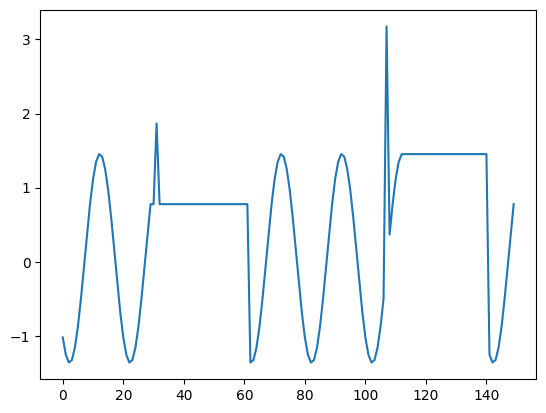

In [115]:
plt.plot(dataset.sine_wave.detach().cpu().numpy())

(32, 100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)
(100, 2)


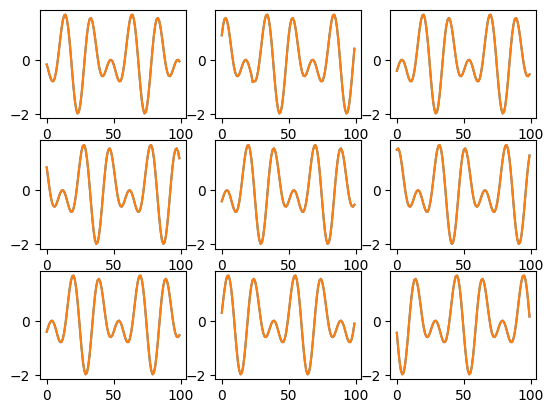

In [42]:
x_aux=next(iter(dataloader))
x_aux=x_aux.cpu().detach().numpy()
print(x_aux.shape)
for i in range(9):
    plt.subplot(3,3,1+i)
    print(x_aux[i].shape)
    plt.plot(x_aux[i])

In [43]:


class AnomalyModel:
    def __init__(self, AnomalyTransformer, dataset, batch_size=16,window_size=100,enc_in=1,enc_out=1, d_model=64, n_heads=2, e_layers=2, d_ff=32,
                 dropout=0.1, activation='relu',  lambda_=1e-3,max_norm=0.1,norm_type=2):
        self.model = AnomalyTransformer(window_size, enc_in, enc_out, d_model, n_heads, e_layers, d_ff, dropout, activation, output_attention=True)
        self.model.cuda()
        self.N=e_layers
        self.model = self.xavier_initialization(self.model)
        self.dataset=dataset
        self.dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        self.lambda_ = lambda_
        self.max_norm=max_norm
        self.norm_type=norm_type

    @staticmethod
    def xavier_initialization(model):
        for module in model.modules():
            if hasattr(module, 'weight') and module.weight is not None and module.weight.dim() >= 2:
                nn.init.xavier_uniform_(module.weight)
                if hasattr(module, 'bias') and module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        return model

    @staticmethod
    def my_kl_loss(p, q):
        res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
        return torch.mean(torch.sum(res, dim=-1), dim=1)

    @staticmethod
    def layer_association_discrepancy(Pl, Sl):
        B, Head, Height, _ = Pl.shape
        kl1 = AnomalyModel.my_kl_loss(Pl.view(B, Head, Height, -1), Sl.view(B, Head, Height, -1))
        kl2 = AnomalyModel.my_kl_loss(Sl.view(B, Head, Height, -1), Pl.view(B, Head, Height, -1))
        ad_vector = kl1 + kl2
        return ad_vector

    @staticmethod
    def association_discrepancy(P_list, S_list):
        return torch.stack([AnomalyModel.layer_association_discrepancy(j/torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100),i) for i, j in zip(S_list,P_list)]).mean(axis=[0])

    @staticmethod
    def loss_function(x_hat, P_list, S_list, lambda_, x):
        frob_norm = ((x_hat - x)**2).sum()
        diss_norm = torch.mean(AnomalyModel.association_discrepancy(P_list, S_list))
        print(frob_norm, diss_norm)
        return (frob_norm.item(), diss_norm.item()), frob_norm - (lambda_ * diss_norm)

    @staticmethod
    def min_loss(output, P_layers, S_layers, x, lambda_):
        P_list = P_layers
        S_list = [S.detach() for S in S_layers]
        lambda_ = -lambda_
        _, loss_value = AnomalyModel.loss_function(output, P_list, S_list, lambda_, x)
        return loss_value

    @staticmethod
    def max_loss(output, P_layers, S_layers, x, lambda_):
        P_list = [P.detach() for P in P_layers]
        S_list = S_layers
        lambda_ = lambda_
        details, loss_value = AnomalyModel.loss_function(output, P_list, S_list, lambda_, x)
        return details, loss_value
    
    def cosine_lr_schedule_with_warmup(self, optimizer, epoch, initial_lr, total_epochs, warmup_epochs):
        if epoch < warmup_epochs:
            lr = initial_lr * (epoch + 1) / warmup_epochs
        else:
            adjusted_epoch = epoch - warmup_epochs
            adjusted_total_epochs = total_epochs - warmup_epochs
            lr = 0.5 * initial_lr * (1 + math.cos(math.pi * adjusted_epoch / adjusted_total_epochs))

        for param_group in optimizer.param_groups:
            param_group['lr'] = lr


    def clip_gradients(self):
        """
        Clip gradients of the model parameters.

        Args:
            model (torch.nn.Module): The neural network model.
            max_norm (float): The maximum allowed norm for the gradients.
            norm_type (float): The type of the norm calculation (default: 2 for L2 norm).
        """
        # Recupera todos los gradientes de los parámetros del modelo
        gradients = [param.grad for param in self.model.parameters() if param.grad is not None]

        # Calcula la norma total de los gradientes
        total_norm = torch.norm(torch.stack([torch.norm(grad, self.norm_type) for grad in gradients]), self.norm_type)

        # Calcula el factor de escalado para recortar los gradientes
        clip_coef = self.max_norm / (total_norm + 1e-6)
        if clip_coef < 1:
            # Aplica el factor de escalado a los gradientes
            for grad in gradients:
                grad.mul_(clip_coef)



    def schedule_lambda(self,epoch,num_epochs,init_lambda,final_lambda):
        self.lambda_=(final_lambda-init_lambda)/num_epochs * epoch + init_lambda
        
    def train(self, num_epochs, initial_lr, warmup_epochs,init_lambda,final_lambda):
        optimizer = optim.Adam(self.model.parameters(), lr=initial_lr)

        self.model.train()
        loss_frob_diss = []

        for epoch in range(num_epochs):
            print(f"Epoch: {epoch}")
            self.schedule_lambda(epoch,num_epochs,init_lambda,final_lambda)
            for i, (inputs) in enumerate(self.dataloader):
                inputs = inputs.float().to("cuda:0")
                outputs, series, prior, _ = self.model(inputs)
                prior = [j / torch.unsqueeze(torch.sum(j, dim=-1), dim=-1).repeat(1, 1, 1, 100) for j in prior]



                loss_min = self.min_loss(outputs, prior, series, inputs, self.lambda_)
                loss_min.backward(retain_graph=True)
                optimizer.step()
                optimizer.zero_grad()

                details, loss_max = self.max_loss(outputs, prior, series, inputs, self.lambda_)
                loss_max.backward()
                optimizer.step()
                optimizer.zero_grad()

                loss_frob_diss.append(list(details))

                #loss_max.backward(retain_graph=True)
                #loss_min.backward()
                if self.max_norm is not None:
                    self.clip_gradients()
                #optimizer.step()
                #optimizer.zero_grad()

                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(self.dataloader)}], Loss: {loss_max.item():.4f}")
            if warmup_epochs is not None:
                self.cosine_lr_schedule_with_warmup(optimizer, epoch, initial_lr, num_epochs, warmup_epochs)

        print("Entrenamiento finalizado")
        return np.array(loss_frob_diss)
    
    def predict(self, data=None):
        if data is None:
            data = next(iter(self.dataloader)).float().to("cuda:0")
        else:
            data = torch.tensor(data).float()
            data = data.to("cuda:0") # .unsqueeze(0) -> esto si solo tiene un canal y no lo hemos puesto

        self.model.eval()
        with torch.no_grad():
            out, series, prior, sigmas = self.model(data)

        out = out.cpu().numpy()
        series = [s.cpu().numpy() for s in series]
        prior = [p.cpu().numpy() for p in prior]
        sigmas = [sigma.cpu().numpy() for sigma in sigmas]

        return data.cpu().detach().numpy(),out, series, prior, sigmas


    def anomaly_score(self, input=None, crit_batch_size=32):
        if input is None:
            input = self.dataset.array

        input = input.float().to("cuda:0")
        self.model.eval()
        num_batches = int(input.size(0) / crit_batch_size) + (1 if input.size(0) % crit_batch_size != 0 else 0)

        # Inicializa un tensor vacío para almacenar los resultados
        result = torch.empty(0, device="cuda:0")

        for i in range(num_batches):
            batch_start = i * crit_batch_size
            batch_end = min((i + 1) * crit_batch_size, input.size(0))

            # Procesa el lote actual
            input_batch = input[batch_start:batch_end]
            out, series, prior, sigmas = self.model(input_batch)
            ad = F.softmax(
                -AnomalyModel.association_discrepancy(prior, series), dim=0
            )

            norm = ((out - input_batch) ** 2).sum(axis=-1)

            score = torch.mul(ad, norm)

            # Añade el resultado del lote actual al tensor de resultado
            result = torch.cat((result, score), dim=0)

        return result



    def evaluate(self,data):
        #esto acepta una serie temporal, y si no se la pasamos usa la que tenia por defecto.
        #la vamos a evaluar enventanada y por partes, y luego, vamos a hacer la media de todas las lecturas del assdiss que recojamos 
        pass


In [44]:

# Instanciar la clase AnomalyModel con el conjunto de datos creado
dataset = Data_anomSine(length=4*530, sf=0.1, f=0.5, phase=4, anoms=7, magnitud=2.5,noise_amp=0)

model_instance = AnomalyModel(AnomalyTransformer.AnomalyTransformer, dataset,enc_in=2,enc_out=2,max_norm=None)
#model_instance.lambda_=schedule_lambda()
# Parámetros de entrenamiento
num_epochs = 40
initial_lr = 0.001
warmup_epochs = 7

# Entrenar la instancia de la clase AnomalyModel

loss_frob_diss = model_instance.train(num_epochs, initial_lr,warmup_epochs,0.001,0.01)

# Ahora puedes usar 'model_instance' para hacer predicciones utilizando el método 'predict'


Epoch: 0
tensor(5764.9058, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.7124, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5764.9058, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.7124, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/40], Step [1/127], Loss: 5764.8970
tensor(9657.7383, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.6687, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(9657.7383, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.6687, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/40], Step [2/127], Loss: 9657.7295
tensor(4106.8877, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.6387, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(4106.8877, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.6387, device='cuda:0', grad_fn=<MeanBackward0>)
Epoch [1/40], Step [3/127], Loss: 4106.8789
tensor(3643.7227, device='cuda:0', grad_fn=<SumBackward0>) tensor(8.6214, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(3643.7227, device='cuda:0', grad_fn=<Sum

In [45]:
dat,out, series, prior, sigmas=model_instance.predict()

In [46]:
dat.shape

(16, 100, 2)

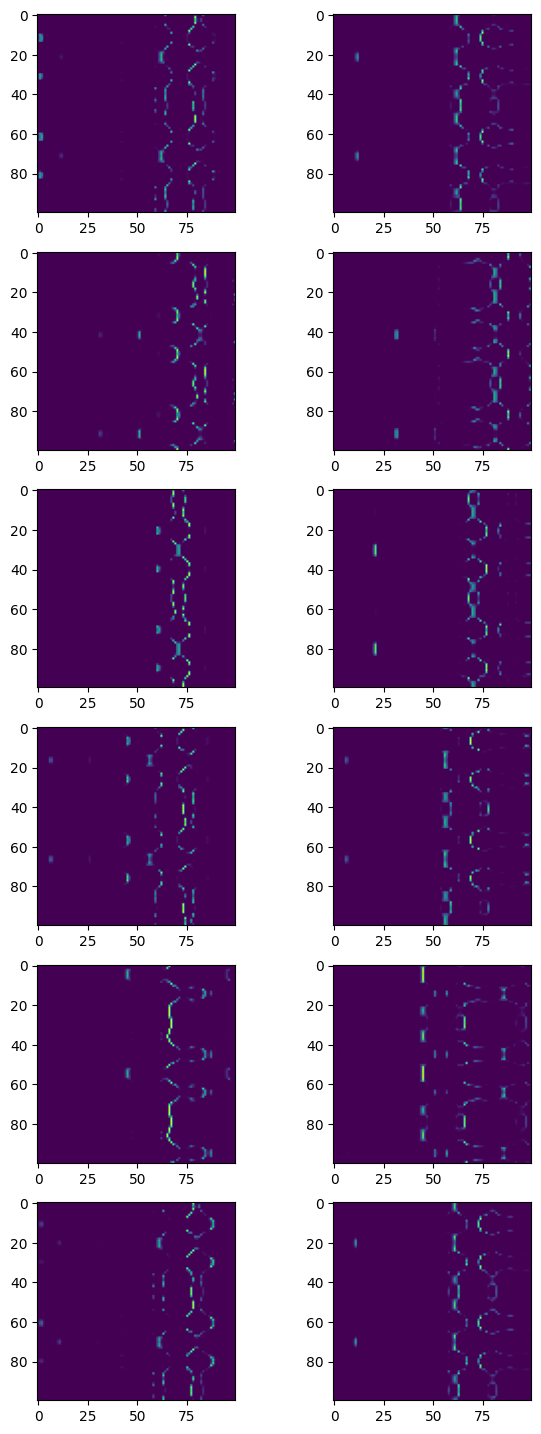

In [19]:
#plot el asociation
plt.figure(figsize=(7,18))
for i in range(6):
    plt.subplot(6,2,i*2+1)
    plt.imshow(series[1][i,0])
    plt.subplot(6,2,i*2+2)
    plt.imshow(series[1][i,1])

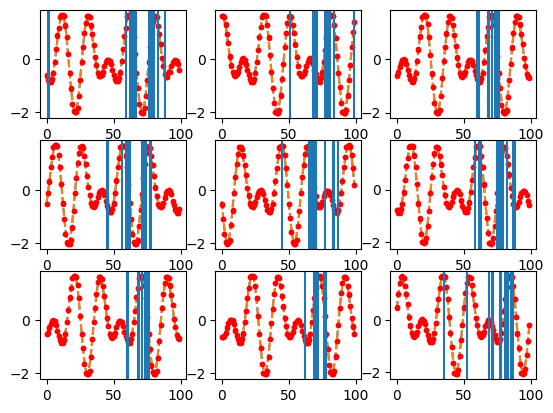

In [20]:
for j in range(9):
    plt.subplot(3,3,j+1)
    a=series[1][j,0]
    indx=np.unique(np.argwhere(a>np.percentile(a,99))[:,1])
    plt.plot(dat[j],"--")
    plt.plot(out[j],".r")
    for i in indx:
        plt.axvline(i)

(array([0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

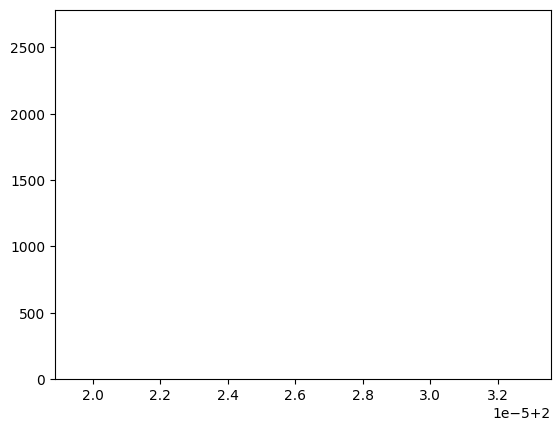

In [21]:
plt.hist(sigmas[1][:,:,:,0].flatten(),bins=400)

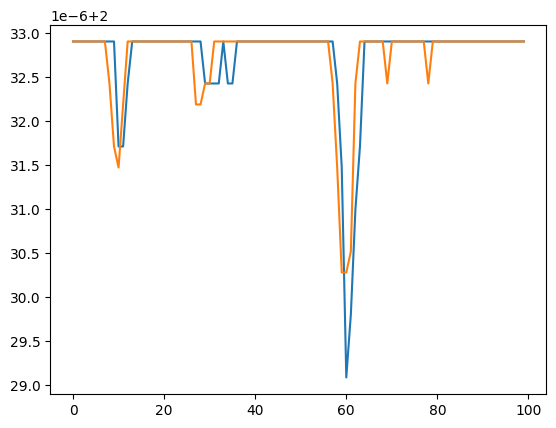

In [22]:
plt.plot(sigmas[1][0][0][:,0])
plt.plot(sigmas[1][12][0][:,0])

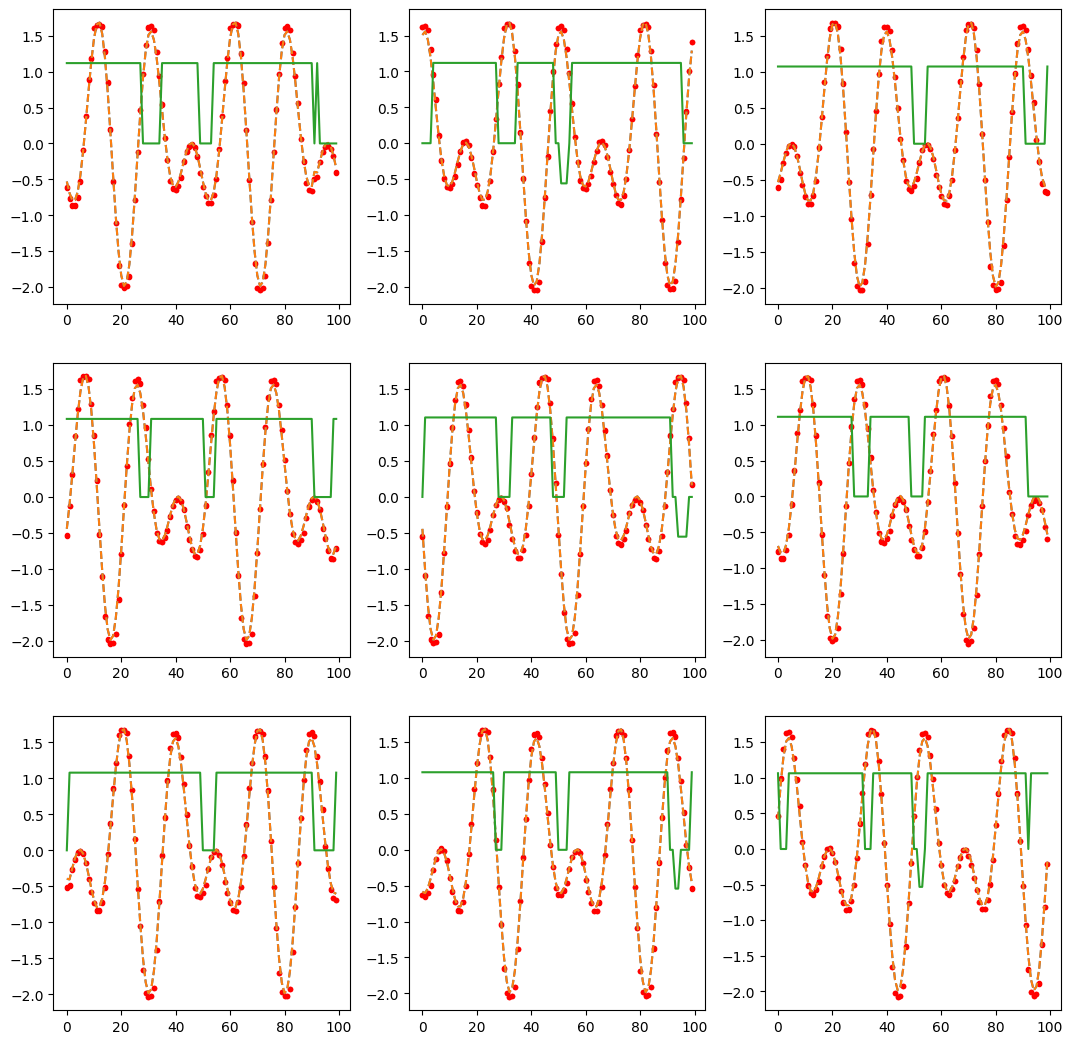

In [23]:
plt.figure(figsize=(13,13))
stand=lambda X: (X - X.mean())/(X.std())
j=1
for i in range(0,9):
    plt.subplot(3,3,j)
    j=j+1
    plt.plot(out[i],".r")
    plt.plot(dat[i],"--")
    plt.plot(stand(sigmas[0][i,0,:,0]))


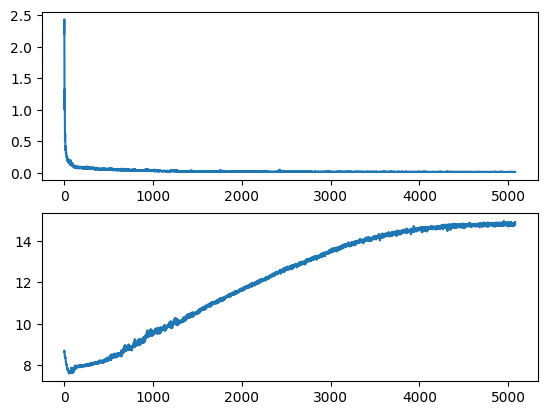

In [24]:
plt.subplot(2,1,1)
plt.plot(loss_frob_diss[:,0])
plt.subplot(2,1,2)
plt.plot(loss_frob_diss[:,1])

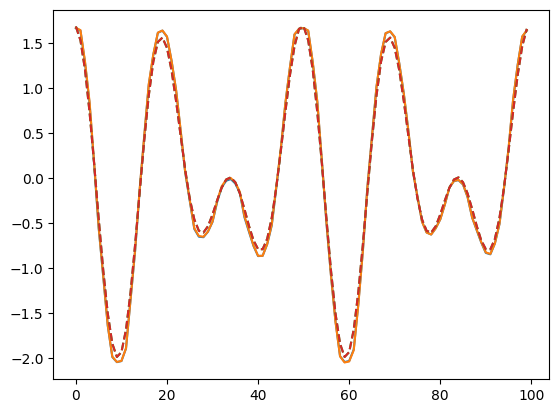

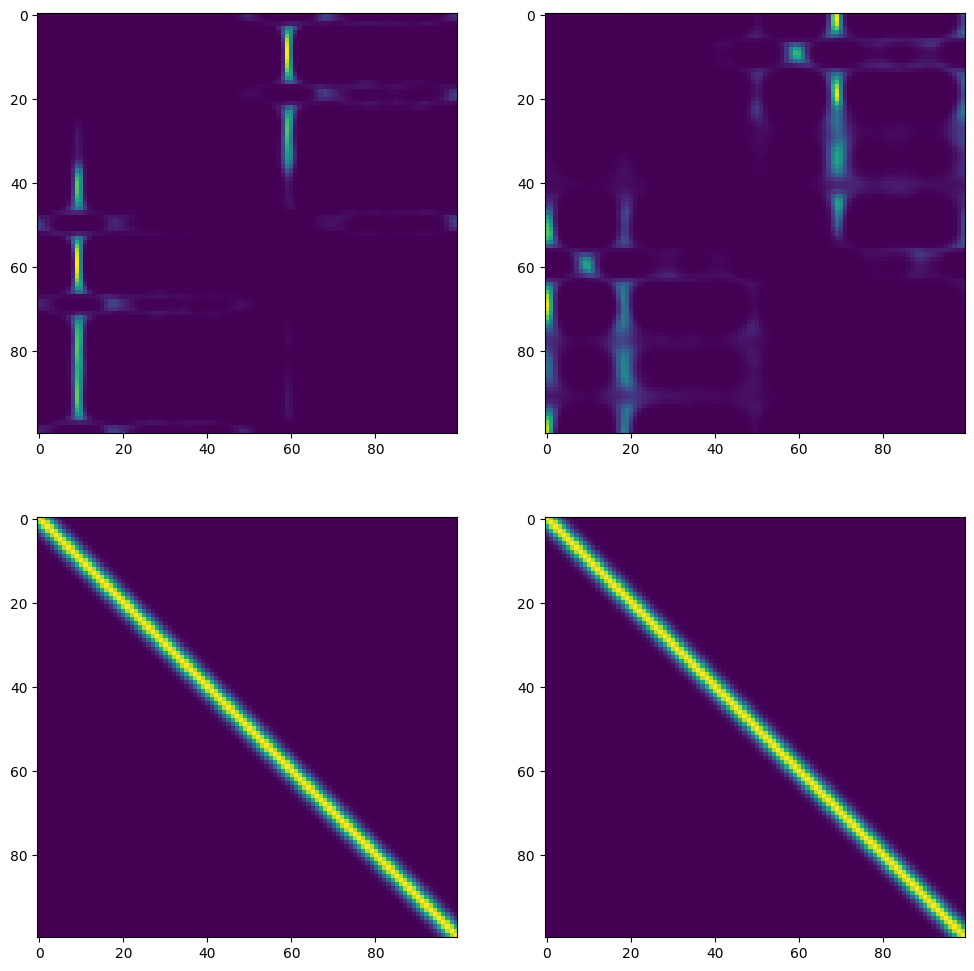

In [25]:
n=15

plt.plot(out[n])
plt.plot(dat[n],"--")
plt.figure(figsize=(12,12))
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.imshow(series[0][n][i])
    plt.subplot(2,2,i+3)
    plt.imshow(prior[0][n][i])

## Evaluación de las predicciones

Para evaluar las predicciones, tenemos que tener un umbral y un criterio para cuando dar por buena una detección.  
El umbral será seleccionado en función del % de anomalías se creemos que hay, y con un percentil o una selección inteligente de esto, se pondrá un umbral.  
Y el criterio será, que si una anomália de una bloque de ellas, es detectada, todas son dadas por buenas. Y esta pendiente una cuestión. Damos por buenas todas las anomalías como si se hubiera adivinado todas, o consideramos todo el cluster como una buena 1 anomalía. Es decir, si hay dos grupos de 400 datos cada uno, que son anomalías, y detectamos una anomalía en cada uno de ellos, hemos acertado 2 anomalías.  

In [26]:
a=model_instance.anomaly_score()

In [27]:
a


tensor([[7.7042e-04, 2.1352e-03, 2.3215e-05,  ..., 3.1392e-05, 1.1612e-06,
         1.2760e-03],
        [2.5749e-03, 2.0231e-05, 4.5161e-06,  ..., 6.2229e-06, 9.2970e-04,
         1.1467e-03],
        [8.3547e-06, 3.8577e-06, 1.0031e-03,  ..., 1.0792e-03, 1.2630e-03,
         8.1517e-04],
        ...,
        [1.0332e-03, 2.2111e-03, 5.1536e-03,  ..., 1.9495e-03, 1.4482e-03,
         4.8568e-04],
        [1.8608e-03, 5.8705e-03, 5.1014e-03,  ..., 1.6298e-03, 4.1093e-04,
         2.1181e-03],
        [6.3489e-03, 5.4900e-03, 2.6039e-03,  ..., 7.4022e-04, 6.1713e-04,
         3.5423e-03]], device='cuda:0', grad_fn=<CatBackward0>)

In [28]:
empt=torch.empty(len(dataset),dataset.sine_wave.shape[0])
empt[:]=float("nan")

In [29]:
for i,j in enumerate(a):
    empt[i,i:(i+100)]=j

In [30]:
empt.shape

torch.Size([2021, 2120])

In [31]:
np.nanmean(empt.cpu().detach().numpy(),axis=0).shape

(2120,)

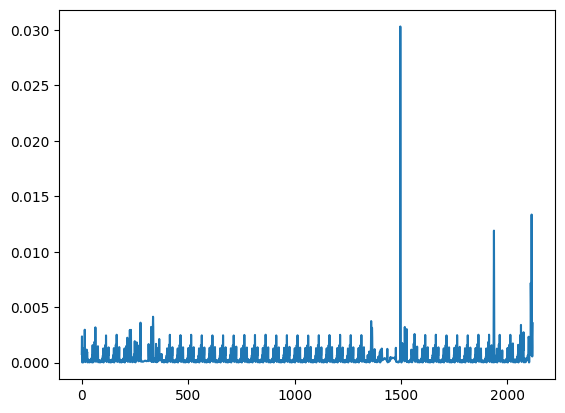

In [32]:
plt.plot(np.nanmean(empt.cpu().detach().numpy(),axis=0))

In [33]:
len(dataset.list_anomalies)

10

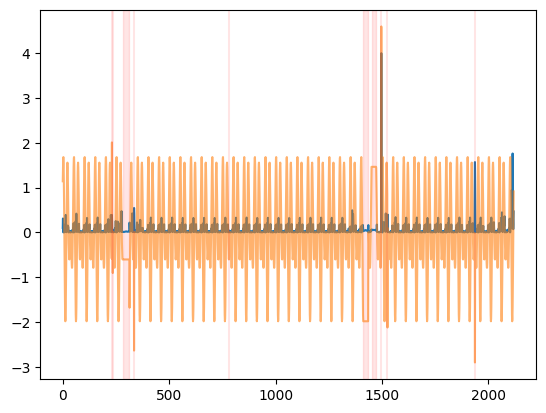

In [34]:
mean_aux=np.nanmean(empt.cpu().detach().numpy(),axis=0)
plt.plot(4*mean_aux/mean_aux.max())
plt.plot(dataset.sine_wave.cpu().detach().numpy(),alpha=0.6)

for i in dataset.list_anomalies:
    if len(i)==1:
        plt.axvline(i[0],alpha=0.1,color="red")
    else:
        plt.axvspan(i[0],i[-1],alpha=0.1,color="red")

In [ ]:
dataset.array.shape

torch.Size([2021, 100, 1])

## Plots para el tfm 

Sobre las anomalias sintéticas

In [116]:
d = Data_anomSine(length=2*130, sf=0.05, f=0.5, phase=4, anoms=2,anoms_c=1, magnitud=1.5,noise_amp=0)

In [117]:
d.sine_wave.cpu().detach().numpy()

array([-1.0202636 , -1.1516    , -1.2533674 , -1.3230598 , -1.3589612 ,
       -1.3601876 , -1.3267089 , -1.2593493 , -1.1597675 , -1.0304155 ,
       -0.8744783 , -0.6957957 , -0.49876744, -0.28824568, -0.06941282,
        0.15234205,  0.37155864,  0.5828391 ,  0.7809809 ,  0.9611052 ,
        1.1187768 ,  1.2501129 ,  1.3518806 ,  1.4215727 ,  1.4574741 ,
        1.4587005 ,  1.4252219 ,  1.3578624 ,  1.2582806 ,  1.1289287 ,
        0.97299147,  0.79430884,  0.5972806 ,  0.38675818,  0.16792528,
       -0.05382959, -0.27304617, -0.48432654, -0.68246835, -0.8625926 ,
       -1.0202641 , -1.1516005 , -1.470459  , -1.32306   , -1.3589613 ,
       -1.3601876 , -1.3267088 , -1.2593498 , -1.1597667 , -1.0304153 ,
       -0.87447816, -0.6957955 , -0.49876723, -0.28824478, -0.0694119 ,
        0.15234298,  0.37155822,  0.5828387 ,  0.7809805 ,  0.96110487,
        1.1187766 ,  1.2501129 ,  1.3518803 ,  1.4215728 ,  1.4574741 ,
        1.4587005 ,  1.4252217 ,  1.357862  ,  1.25828   ,  1.12

In [122]:
d2.list_anomalies

[[21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [62],
 [115]]

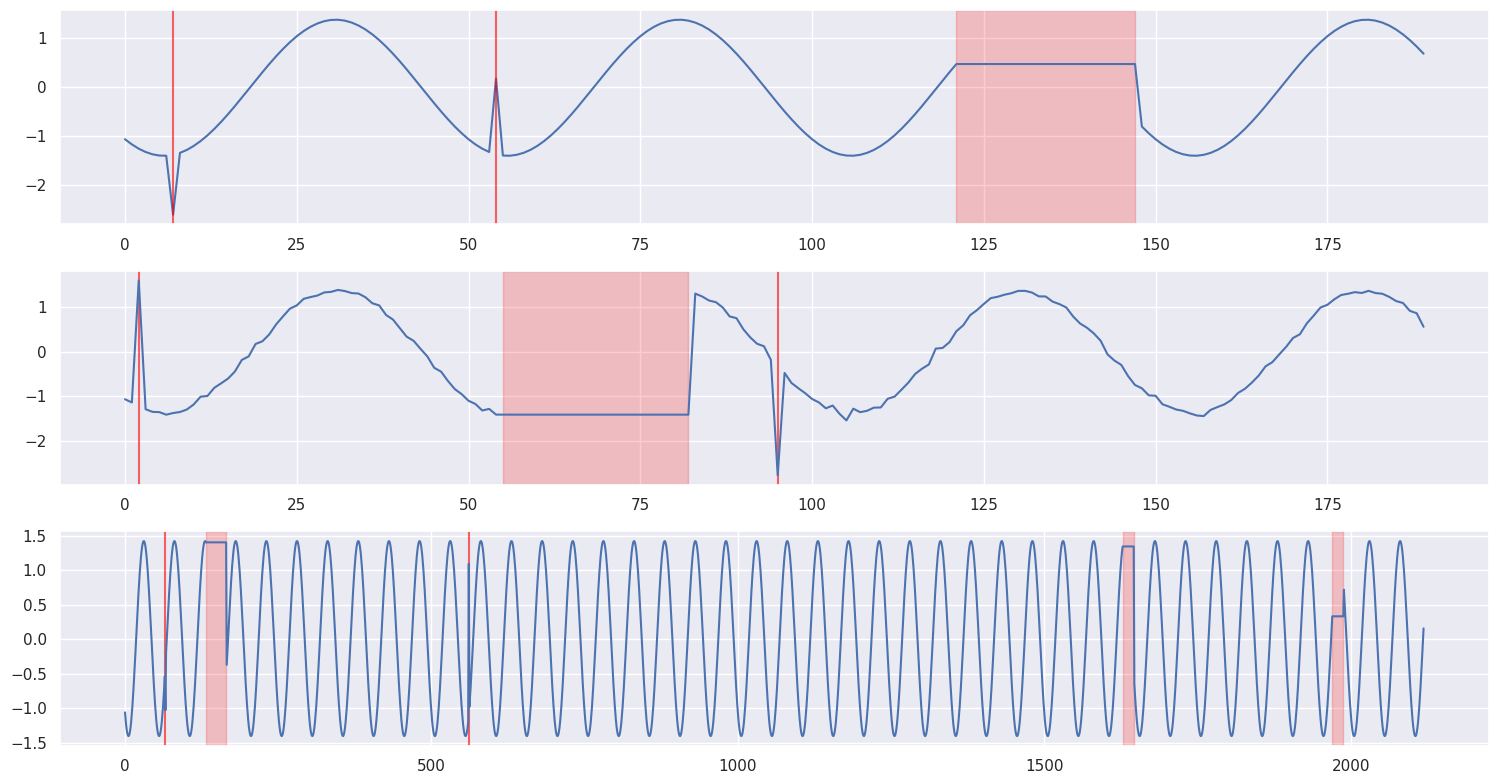

In [11]:
plt.figure(figsize=(15,8))
plt.subplot(3,1,1)
d = Data_anomSine(length=190, sf=0.05, f=0.4, phase=4, anoms=2,anoms_c=1, magnitud=1.5,noise_amp=0)
plt.plot(d.sine_wave.cpu().detach().numpy())
for i in d.list_anomalies:
    if len(i)==1:
        plt.axvline(i[0],alpha=.6,color="red")
    else:
        plt.axvspan(i[0],i[-1],alpha=.2,color="red")
plt.subplot(3,1,2)

d2 = Data_anomSine(length=190, sf=0.05, f=0.4, phase=4, anoms=2,anoms_c=1, magnitud=1.5,noise_amp=1/30)
for i in d2.list_anomalies:
    if len(i)==1:
        plt.axvline(i[0],alpha=.6,color="red")
    else:
        plt.axvspan(i[0],i[-1],alpha=.2,color="red")
plt.plot(d2.sine_wave.cpu().detach().numpy())

plt.subplot(3,1,3)

d4 = Data_anomSine(length=4*530, sf=0.05, f=0.4, phase=4, anoms=2,anoms_c=3,f_envelope=0.0002, magnitud=1.5,noise_amp=0)
for i in d4.list_anomalies:
    if len(i)==1:
        plt.axvline(i[0],alpha=.6,color="red")
    else:
        plt.axvspan(i[0],i[-1],alpha=.2,color="red")

plt.plot(d4.sine_wave.cpu().detach().numpy())

plt.tight_layout()

plt.savefig("../../visualizaciones_tfm/imgs/ejemplo_anom4.png")